In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Initial Data Preprocessing**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

df1=pd.read_csv('drive/My Drive/CMO_MSP_Mandi.csv')
df2=pd.read_csv('drive/My Drive/Monthly_data_cmo.csv')

df1['commodity']=df1['commodity'].str.lower()
df1['Type']=df1['Type'].str.lower()
df1 = df1[df1['year'] != 2012]
df1 = df1[df1['year'] != 2013]
df1['year']=pd.to_datetime(df1['year'],format= '%Y')
df1=df1.dropna(how='any',axis=0)

df2['is_duplicate']=df2.duplicated()
df2['APMC']=df2['APMC'].str.lower()
df2['Commodity']=df2['Commodity'].str.lower()


**Checking of NULL values in the Monthly_data_cmo.csv**

In [76]:
df2.isna().sum()

APMC               0
Commodity          0
Year               0
Month              0
arrivals_in_qtl    0
min_price          0
max_price          0
modal_price        0
date               0
district_name      0
state_name         0
is_duplicate       0
dtype: int64

**Redundant columns were dropped**

In [0]:
df2=df2.drop((['is_duplicate','state_name']),axis=1)

**'date' column is converted to pandas timestamp**

In [0]:
df2['date']=pd.to_datetime(df2['date'])
df2=df2.sort_values('date')

In [0]:
#x=df2.loc[(df2['Commodity']=='orange')]
#x['min_price'].describe()
#x.boxplot(column='min_price',by=['Commodity','Year'])


# **Task-1 : Test and filter outliers.**

In [0]:
for x in list(df2[['min_price','max_price','modal_price']]):
  q1=df2.groupby(['Commodity','Year'])[x].quantile(0.25)
  q3=df2.groupby(['Commodity','Year'])[x].quantile(0.75)
  iqr=q3-q1
  lower_bound=q1-(1.5*iqr)#outlier lower bound
  upper_bound=q3+(1.5*iqr)#outlier lower bound
  
  lim_dict  = {}# (comm,year):(lower,upper)
  for commo in df2['Commodity'].unique():
    for year_ in df2['Year'].unique():
      try:
        temp = upper_bound.iloc[upper_bound.index.get_level_values('Year') == year_]
        up_b= temp.iloc[temp.index.get_level_values('Commodity') == commo].values[0]

        temp = lower_bound.iloc[lower_bound.index.get_level_values('Year') == year_]
        lw_b= temp.iloc[temp.index.get_level_values('Commodity') == commo].values[0]

        lim_dict[tuple([commo,year_])] = tuple([lw_b,up_b])
      except:
        pass
  def check_outlier(x):#function to detect the outliers
    lw_b,up_b = lim_dict[(x['Commodity'],x['Year'])]
    if x['modal_price']>=lw_b and x['modal_price']<=up_b:
      return False
    return True
  df2['outlier_det'] = df2.apply(check_outlier,axis=1)
  df2=df2[df2['outlier_det']==False]
  

**Output csv without outliers**

In [0]:
df2.to_csv("Filtered_Outlier_data.csv")
!cp Filtered_Outlier_data.csv drive/My\ Drive/

In [0]:
#x=df2.loc[(df2['Commodity']=='orange')]
#x['min_price'].describe()
#x.boxplot(column='min_price',by=['Commodity','Year'])

# Task-2.1 : Detect seasonality type (multiplicative or additive) for each cluster of APMC and commodities


**2.1.1 New column of combination of APMC and Commodity is formed**

In [0]:
df2['APMC_commodity']=df2['APMC']+"+"+df2['Commodity']
new_df2=df2[["APMC","Commodity","modal_price","Year","APMC_commodity"]].groupby(["APMC","Commodity","Year","APMC_commodity"],as_index=False).count().reset_index(drop=True)
new_df2 = new_df2[new_df2['modal_price']==12].reset_index(drop=True)
#new_df2.sort_values('Year')
#len(new_df2['APMC_commodity'].unique().tolist()) 

**2.1.2 Only continuous time series data is selected for further analysis**

In [0]:
df2_seasonal=new_df2['APMC_commodity'].unique().tolist()
df2_seasonal=df2[df2['APMC_commodity'].isin(df2_seasonal)].reset_index(drop=True)
df2_seasonal=df2_seasonal.drop((['APMC','Commodity','Year','Month','arrivals_in_qtl','min_price','max_price','district_name','outlier_det']),axis=1)
df2_seasonal=df2_seasonal.set_index('date')

**2.1.3 Detection of stationary and non-stationary time series by ADF statistical test **

In [84]:
stationary_list=[]
#stat_list=[]
def detect_stationary(col):#function to check stationary and non-stationary time series, returns p-value
  return tsa.adfuller(col['modal_price'],autolag='AIC')[1]
stationary_list=df2_seasonal.groupby('APMC_commodity').apply(detect_stationary)
#stationary_list[stationary_list['APMC_commodity']=='akluj+brinjal']
stationary_list['APMC_commodity']=stationary_list.index
stationary_list=stationary_list.reset_index()
stationary_list.columns=['APMC_commodity','p-value']
stationary_list=stationary_list.fillna(0)
stationary_list.isnull().sum()
last_row = len(stationary_list)
last_row = last_row-1
stationary_list = stationary_list.drop(stationary_list.index[last_row])
stationary_list.tail()
stationary_list['p-value']=stationary_list['p-value'].astype(str)
stationary_list['p-value']=stationary_list['p-value'].astype(float)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


**2.1.4 If p-value > 0.05, then time series in non-stationary** **bold text**

In [0]:
stationary_list['p-value']=stationary_list['p-value']>0.05#only non-stationary time series are considered for further analysis
stationary_list=stationary_list[stationary_list['p-value']==True]

In [0]:
df2_stat=stationary_list['APMC_commodity'].unique().tolist()
df2_seasonal=df2_seasonal[df2_seasonal['APMC_commodity'].isin(df2_stat)]
#df2_seasonal.head()

In [0]:

#df2_seasonal.head()
#df2_seasonal.isna().sum()
#distinct=df2_seasonal[df2_seasonal['APMC_commodity']=='kurdwadi+sorgum(jawar)']
#distinct
#df2_seasonal.head()

**2.1.5 Code for type of seasonality detection**

In [0]:
apmc_comm=list(df2_seasonal['APMC_commodity'].unique())
seasonality_type=[]

def detect_seasonality_type(distinct):#function for detection of type of seasonality present in the non-stationary time series
  distinct=distinct.drop((['APMC_commodity']),axis=1)
  
  distinct = distinct.resample('MS').mean()
  distinct = distinct.fillna(int(distinct['modal_price'].mean()))
   
  decompose_add=seasonal_decompose(distinct,model='additive',freq=6)
  decompose_multiply=seasonal_decompose(distinct,model='multiplicative',freq=6)
  
  acf_add=sum(np.asarray(acf(decompose_add.resid,missing='drop')*2))
  acf_multiply=sum(np.asarray(acf(decompose_multiply.resid,missing='drop')*2))
    
  if acf_add>acf_multiply:
   return "multiplicative"
  else:
   return "additive"
  
for c in apmc_comm:
   distinct=df2_seasonal[df2_seasonal['APMC_commodity']==c]
   seasonality_type.append((c,detect_seasonality_type(distinct)))    

**2.1.6 Seasonality type csv is obtained**

In [0]:
final_seasonality_type=pd.DataFrame(seasonality_type)
final_seasonality_type.columns=['APMC_commodity','seasonality_type']
final_seasonality_type.head()
final_seasonality_type.to_csv('Seasonality_type_data.csv')
!cp Seasonality_type_data.csv drive/My\ Drive/
#distinct.head()

# **Task - 2.2 : De-seasonalise prices for each commodity and APMC according to the detected seasonality type**

In [94]:
deseasonalize_data=pd.DataFrame()

def deseasonalize_price(de_distinct,types):#function to deseasonalise the prices
  de_distinct1 = de_distinct.resample('MS').mean()
  de_distinct1 = de_distinct1.fillna(int(de_distinct['modal_price'].mean()))
  if 'additive' in types:
    de_decompose_add=seasonal_decompose(de_distinct1,model='additive',freq=6)
    de_distinct1['seasonal_price']=de_decompose_add.seasonal.values
    de_distinct1['deseasonalized_price']=de_distinct1['modal_price']-de_distinct1['seasonal_price']
  else:
    de_decompose_multiply=seasonal_decompose(de_distinct1,model='multiplicative',freq=6)
    de_distinct1['seasonal_price']=de_decompose_multiply.seasonal.values
    de_distinct1['deseasonalized_price']=de_distinct1['modal_price']/de_distinct1['seasonal_price']
    
  return de_distinct1

for c1 in apmc_comm:
  de_distinct=df2_seasonal[df2_seasonal['APMC_commodity']==c1]
  types=final_seasonality_type.loc[final_seasonality_type['APMC_commodity']==c1,'seasonality_type'].reset_index(drop=True)[0]
  if(types=='additive'):
    de_data=deseasonalize_price(de_distinct,'additive')
  else:
    de_data=deseasonalize_price(de_distinct,'multiplicative')
  de_data['APMC_commodity']=c1  
  deseasonalize_data=pd.concat([deseasonalize_data,de_data])
  
deseasonalize_data = deseasonalize_data.dropna(how='any',axis=0)
#deseasonalize_data.head()


,modal_price,seasonal_price,deseasonalized_price,APMC_commodity
date,,,,
2014-09-01,1981.0,20.400463,1960.599537,kurdwadi+sorgum(jawar)
2014-10-01,1779.0,-85.460648,1864.460648,kurdwadi+sorgum(jawar)
2014-11-01,1973.0,58.733796,1914.266204,kurdwadi+sorgum(jawar)
2014-12-01,1861.0,36.796296,1824.203704,kurdwadi+sorgum(jawar)
2015-01-01,1840.0,-41.703704,1881.703704,kurdwadi+sorgum(jawar)


**Deseasonalise data csv is obtained**

In [0]:
deseasonalize_data.to_csv('deseasonalize_price_data.csv')
!cp deseasonalize_price_data.csv drive/My\ Drive/

# Task-3 : Compare prices in APMC/Mandi with MSP(Minimum Support Price)- raw and deseasonalised

In [0]:
def comparison(apmc,commodity):#function to compare the price in msp vs actual vs deseasonalised price
  apmc_comm=str(apmc)+"+"+str(commodity)
  new_data=deseasonalize_data[deseasonalize_data['APMC_commodity']==apmc_comm]
  df1_msp=df1[df1['commodity']=='bajri']
  df1_msp=df1_msp[['year','msprice']]
  xaxis = new_data.index
  plt.figure(figsize=(10, 6))
  plt.plot(new_data.index, new_data['modal_price'])
  plt.plot(new_data.index, new_data['deseasonalized_price'])
  plt.plot(df1_msp['year'], df1_msp['msprice'], color = 'k')
  ax = plt.gca()
  plt.legend(['Actual price', 'Deseasonalized', 'MSP'])
  plt.show()

**Input the APMC and Commodity**

Enter the APMC name:karwadi
Enter the Commodity in the above APMC:sorgum(jawar)


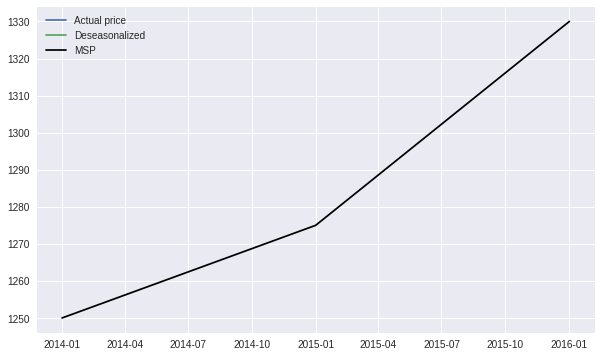

In [97]:
apmc=input('Enter the APMC name:')
commodity=input('Enter the Commodity in the above APMC:')
comparison(apmc,commodity)

In [0]:
#df2.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,outlier_det,APMC_commodity
54791,kurdwadi,sorgum(jawar),2014,September,454,1353,2610,1981,2014-09-01,Solapur,False,kurdwadi+sorgum(jawar)
50564,satara,ladies finger,2014,September,128,2435,3261,2848,2014-09-01,Satara,False,satara+ladies finger
50561,satara,potato,2014,September,2988,2175,2488,2331,2014-09-01,Satara,False,satara+potato
50558,satara,ginger (fresh),2014,September,199,3438,4813,4125,2014-09-01,Satara,False,satara+ginger (fresh)
50556,satara,ground nut pods (dry),2014,September,1,3000,4000,3500,2014-09-01,Satara,False,satara+ground nut pods (dry)


# **Task-4 : Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.**

In [0]:
fluct_data=df2[['APMC','Commodity','Year','Month','min_price','max_price','APMC_commodity']]

In [104]:
fluct_data.head()

,APMC,Commodity,Year,Month,min_price,max_price,APMC_commodity,fluct_price
54791,kurdwadi,sorgum(jawar),2014,September,1353,2610,kurdwadi+sorgum(jawar),1257
50564,satara,ladies finger,2014,September,2435,3261,satara+ladies finger,826
50561,satara,potato,2014,September,2175,2488,satara+potato,313
50558,satara,ginger (fresh),2014,September,3438,4813,satara+ginger (fresh),1375
50556,satara,ground nut pods (dry),2014,September,3000,4000,satara+ground nut pods (dry),1000


In [109]:
fluct_data['fluct_price']=fluct_data['max_price']-fluct_data['min_price']
fluctuation=fluct_data.groupby(['Commodity','APMC','Year']).max()
#fluctuation=fluctuation.drop(['APMC_commodity'])
fluctuation=fluctuation[fluctuation['fluct_price']>0]
#fluctuation=fluctuation[filter_data]
#fluctuation.head()
#filter_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**Fluctuated Data  csv is obtained**

In [0]:
fluctuation.to_csv('fluctuation_data.csv')
!cp fluctuation_data.csv drive/My\ Drive/